In [2]:
# from google.colab import userdata
# HF_TOKEN = userdata.get('HF_TOKEN')
# HF_TOKEN

In [3]:
# import huggingface_hub
# huggingface_hub.login()

In [ ]:
from IPython.display import display
import ipywidgets as widgets

display(widgets.IntSlider())  # or any widget to re-trigger widget state

## Learning HuggingFace Text Classification Tutorial

### Import necessary libraries

In [4]:
try:
  import datasets, evaluate, accelerate
  import gradio as gr
except ModuleNotFoundError:
  !pip install -U datasets evaluate accelerate gradio
  import datasets, evaluate, accelerate
  import gradio as gr

import random

import numpy as np
import pandas as pd

import torch
import transformers

print(f"Using transformers version: {transformers.__version__}")
print(f"Using torch version: {torch.__version__}")
print(f"Using datasets version: {datasets.__version__}")

Using transformers version: 4.51.3
Using torch version: 2.6.0+cu124
Using datasets version: 3.6.0


## Getting the dataset

In [5]:
# Getting food not food text dataset
from datasets import load_dataset

dataset = load_dataset(path="mrdbourke/learn_hf_food_not_food_image_captions")
dataset

README.md:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/250 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
})

In [6]:
dataset.column_names

{'train': ['text', 'label']}

In [7]:
dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 250
})

In [8]:
dataset['train'][0]

{'text': 'Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
 'label': 'food'}

In [9]:
import random

random_indexes = random.sample(range(len(dataset['train'])), 5)
print(random_indexes)

random_samples = dataset['train'][random_indexes]

print(f"Random samples from dataset:")
for text, label in zip(random_samples['text'], random_samples['label']):
  print(f"Text: {text} | Label: {label}")

[29, 47, 200, 76, 91]
Random samples from dataset:
Text: Hammock swaying between two trees | Label: not_food
Text: Wooden hanger holding clothes on a rack | Label: not_food
Text: Ceiling fan with lights illuminating a bedroom | Label: not_food
Text: Set of bowls stacked on a shelf | Label: not_food
Text: Garage door with a remote control ready for use | Label: not_food


In [10]:
random_samples = dataset['train'][random_indexes]
random_samples['text']

['Hammock swaying between two trees',
 'Wooden hanger holding clothes on a rack',
 'Ceiling fan with lights illuminating a bedroom',
 'Set of bowls stacked on a shelf',
 'Garage door with a remote control ready for use']

In [11]:
range(len(dataset['train']))

range(0, 250)

In [12]:
dataset['train'].unique('label')

['food', 'not_food']

In [13]:
# Check the count of each label
from collections import Counter

Counter(dataset['train']['label'])

Counter({'food': 125, 'not_food': 125})

In [14]:
#Turn the dataset into a DataFrame and get a random sample
food_not_food_df = pd.DataFrame(dataset['train'])
food_not_food_df.sample(7)

,text,label
102,A child playing with a golden retriever in the...,not_food
26,"Fresh cherry tomatoes in a basket, sprinkled w...",food
244,Set of napkins dispensed from a dispenser,not_food
48,"Cucumbers on a plate, served with a side of ta...",food
232,"Beets in a bowl, sprinkled with goat cheese an...",food
195,Bicycle leaning casually against a wall,not_food
9,Sushi with unique toppings like seared tuna or...,food


In [15]:
food_not_food_df['label'].value_counts()

,count
label,
food,125
not_food,125


## Preparing data for text classification
1. Tokenize the text - turning text and labels into numbers
2. Create a train/test split - training the model on train split and evaluating on test split.

In [16]:
# Create a mapping for labels to numeric values manually
id2label = {0:"not_food", 1:"food"}
label2id = {"not_food":0, "food":1}

print(id2label,"\n",label2id)

{0: 'not_food', 1: 'food'} 
 {'not_food': 0, 'food': 1}


In [17]:
# Create mappings programmatically from dataset
id2label = {idx: label for idx,label in enumerate(dataset['train'].unique('label')[::-1])}
label2id = {label:idx for idx, label in id2label.items()}
print(id2label)
print(label2id)

{0: 'not_food', 1: 'food'}
{'not_food': 0, 'food': 1}


In [18]:
id2label = {}
for idx, label in enumerate(dataset['train'].unique('label')[::-1]):
  print(idx, label)
  id2label[idx] = label

0 not_food
1 food


In [19]:
id2label
label2id

{'not_food': 0, 'food': 1}

In [20]:
# label2id = {label:idx for idx,label in enumerate(dataset['train'].unique('label')[::-1])}
# label2id

In [21]:
# Turn labels into 0 or 1
def map_labels_to_number(example):
  example['label'] = label2id[example['label']]
  return example

example_sample = {'text': 'This is a sentence about my favourite food: chapati', "label":"food"}

# Test the function
map_labels_to_number(example_sample)

{'text': 'This is a sentence about my favourite food: chapati', 'label': 1}

In [22]:
# Map the dataset labels to numbers (the whole thing)
# Doing this with dataset.map()
dataset = dataset["train"].map(map_labels_to_number)
dataset[:5]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

{'text': ['Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
  'Set of books stacked on a desk',
  'Watching TV together, a family has their dog stretched out on the floor',
  'Wooden dresser with a mirror reflecting the room',
  'Lawn mower stored in a shed'],
 'label': [1, 0, 0, 0, 0]}

In [23]:
# Shuffle data and look at 5 more random samples
dataset.shuffle()[:5]

{'text': ['Lawn mower stored in a shed',
  'A basket of fresh strawberries with a sprinkle of powdered sugar',
  'Treadmill available in a home gym',
  'Pizza with a stuffed crust, oozing with cheese',
  'Black and white checkered kitchen floor adding a classic touch'],
 'label': [0, 1, 0, 1, 0]}

### Split the dataset into training and test sets
* Train set = model learn patterns on this dataset
* Validation set (optional) = tuning the model's hyperparameters on this set.
* Test set = model will evaluate patterns on this dataset


In [24]:
# Split the dataset into train/test splits
dataset = dataset.train_test_split(test_size=0.2, seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

In [25]:
dataset['train'][:10]

{'text': ['Set of headphones placed on a desk',
  'Set of tea towels folded in a kitchen',
  'Set of curtains draped over a window',
  'Treadmill available in a home gym',
  'Remote control placed on a couch cushion',
  'A close-up of a girl feeding her rabbit in the garden',
  "Brushing her cat's fur in her bedroom, a young girl concentrates",
  'Guitar leaning casually against a couch',
  'Taking a nap on a hammock, a man has his dog snuggled up next to him',
  'A close-up of a man and his dog sharing a quiet moment on the porch'],
 'label': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [26]:
random_idx_train = random.randint(0, len(dataset['train']))
random_sample_train = dataset['train'][random_idx_train]
random_sample_train

{'text': 'Telescope positioned on a balcony', 'label': 0}

In [27]:
dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 200
})

In [28]:
random.randint(0, len(dataset['test']))

5

In [29]:
random_idx_test = random.randint(0, len(dataset['test']))
random_sample_test = dataset['test'][random_idx_test]
random_sample_test

{'text': 'Set of measuring cups nested in a drawer', 'label': 0}

### Tokenizing the text data (turning text into numbers)
* Models are often paired with tokenizers.
* Tokenizer - turn text into numbers
* Model - find pattern in those numbers

In [30]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
                                          use_fast=True) # use the fast implementation (on by default, note: this requires Rust installed)

tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [31]:
!nvidia-smi

Sat May 24 10:52:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [32]:
# Testing the tokenizer
tokenizer("I love to drink alcohol on a sunny day, but it do not matter")

{'input_ids': [101, 1045, 2293, 2000, 4392, 6544, 2006, 1037, 11559, 2154, 1010, 2021, 2009, 2079, 2025, 3043, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

 * `input_ids` - text turned into numbers
 * `attention_mask` - whether or not to pay attention to certain tokens(1=yes pay attention, 0=no don't pay attention)

In [33]:
# Get the length of the tokenizer vocab
length_of_tokenizer_vocab = len(tokenizer.vocab)
print(f"Number of items in the vocab: {length_of_tokenizer_vocab}")

# Get the maximum sequence length the tokenizer can handle
max_tokenizer_input_sequence_length = tokenizer.model_max_length
print(f"Max tokenizer inout sequence length: {max_tokenizer_input_sequence_length}")

Number of items in the vocab: 30522
Max tokenizer inout sequence length: 512


In [34]:
tokenizer.vocab['torch']

12723

In [35]:
tokenizer("germs")

{'input_ids': [101, 16216, 10867, 2015, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [36]:
tokenizer.convert_ids_to_tokens(tokenizer("germs").input_ids)

['[CLS]', 'ge', '##rm', '##s', '[SEP]']

In [37]:
tokenizer.convert_ids_to_tokens(tokenizer("germs").attention_mask)

['[unused0]', '[unused0]', '[unused0]', '[unused0]', '[unused0]']

In [38]:
tokenizer.convert_ids_to_tokens(tokenizer("🤤").input_ids)

['[CLS]', '[UNK]', '[SEP]']

In [39]:
tokenizer.convert_ids_to_tokens(tokenizer("☆*: .｡. o(≧▽≦)o .｡.:*☆").input_ids)

['[CLS]',
 '☆',
 '*',
 ':',
 '.',
 '[UNK]',
 '.',
 'o',
 '(',
 '[UNK]',
 ')',
 'o',
 '.',
 '[UNK]',
 '.',
 ':',
 '*',
 '☆',
 '[SEP]']

In [40]:
# tokenizer.vocab

In [41]:
# Get the first 5 items in the tokenizer vocab
sorted(tokenizer.vocab.items())[:5]

[('!', 999), ('"', 1000), ('#', 1001), ('##!', 29612), ('##"', 29613)]

In [42]:
import random

random.sample(sorted(tokenizer.vocab.items()), k=5)

[('glamorgan', 23861),
 ('hereford', 21136),
 ('glasgow', 6785),
 ('supermarkets', 26676),
 ('category', 4696)]

### Making a preprocessing function to tokenize text
Making it easy to go from sample -> tokenized_sample.

In [43]:
def tokenize_text(examples):
  """
  Tokenize given example text and return the tokenized text.
  """
  return tokenizer(examples["text"],
            padding=True, # pad short sequences to longest sequence in batch (e.g. if sample length is 100 and the model length is 512, the sample length will be padded to 512 or longest sample in batch)
            truncation=True)  # Truncate long sequences to the maximum length the model can handle (e.g. if sample length = 1000, model length = 512, sample will be shortened to 512)

In [44]:
example_sample_2 = {'text':'I love pizza', 'label': 1}

tokenize_text(example_sample_2)

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [45]:
long_text = "I love mocha and eggs benedict "*1000
len(long_text)

31000

In [46]:
long_text
example_sample_3 = {"text": long_text, label:1}

In [47]:
tokenized_long_text = tokenize_text(example_sample_3)
len(tokenized_long_text['input_ids']) # truncation checking

512

In [48]:
# Map tokenize text function to the dataset
tokenized_dataset = dataset.map(function=tokenize_text,
                                batched=True, # set batched=True to tokenize across batches of samples at a time rather than one at a time
                                batch_size=1000)
tokenized_dataset

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
})

**In machine learning it is faster to do things in batches than  one at a time due to the leveraging of computer hardware parallelization.**

In [49]:
tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [50]:
tokenizer.all_special_ids

[100, 102, 0, 101, 103]

In [51]:
# Get two samples from the tokenized datasets
train_tokenized_sample = tokenized_dataset['train'][0]
test_tokenized_sample = tokenized_dataset['test'][0]

# trained_tokenized_sample, test_tokenized_sample
for key in train_tokenized_sample.keys():
  print(f"[INFO] Key: {key}")
  print(f"Train sample: {train_tokenized_sample[key]}")
  print(f"Test sample: {test_tokenized_sample[key]}")
  print()

[INFO] Key: text
Train sample: Set of headphones placed on a desk
Test sample: A slice of pepperoni pizza with a layer of melted cheese

[INFO] Key: label
Train sample: 0
Test sample: 1

[INFO] Key: input_ids
Train sample: [101, 2275, 1997, 2132, 19093, 2872, 2006, 1037, 4624, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [101, 1037, 14704, 1997, 11565, 10698, 10733, 2007, 1037, 6741, 1997, 12501, 8808, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[INFO] Key: attention_mask
Train sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



In [52]:
train_tokenized_sample.keys()

dict_keys(['text', 'label', 'input_ids', 'attention_mask'])

## Setting  up Evaluation metric
Some common evaluation metrics for classification:
- Accuracy
- Precision
- Recall
- F1 score

Some projects may have an evaluation threshold needed to be fulfilled.

In [53]:
import evaluate
import numpy as np
from typing import Tuple

accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels:Tuple[np.array, np.array]):
  """
  Computes the accuracy by comparing the predictions and the labels.
  """
  predictions, labels = predictions_and_labels

  return accuracy_metric.compute(predictions=predictions, references=labels)

In [54]:
# Example predictions and accuracy score
example_preds_all_correct = np.array([0,0,0,0,0,0,0,0,0,0])
example_preds_one_incorrect = np.array([0,0,0,0,1,0,0,0,0,0])
example_labels = np.array([0,0,0,0,0,0,0,0,0,0])

# Test the function
print(f"Accuracy when all predictions are correct: {compute_accuracy((example_preds_all_correct, example_labels))}")
print(f"Accuracy when one prediction is incorrect: {compute_accuracy((example_preds_one_incorrect, example_labels))}")

Accuracy when all predictions are correct: {'accuracy': 1.0}
Accuracy when one prediction is incorrect: {'accuracy': 0.9}


## Setting up a model for training
Using transfer learning.

Workflow for training:
1. Create and preprocess data.
2. Define the model you'd like to use for your [problem](https://huggingface.co/models).
3. Define the training arguments for training the model `transformers.TrainingArguments`. Aka hyperparameters.
4. Pass `TrainingArguments` to an instance of `transformers.Trainer`.
5. Train the model by calling `Trainer.train()`.
6. Save the model (to local amchine or HuggingFace Hub).
7. Evaluate the trained model by making and inspecting predictions on the test data.
8. Turn the model into a shareable demo.

In [55]:
label2id

{'not_food': 0, 'food': 1}

In [56]:
id2label

{0: 'not_food', 1: 'food'}

In [57]:
from transformers import AutoModelForSequenceClassification # for loading the model automatically
model_name = "distilbert/distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    num_labels=2, #classify into food/not_food
    id2label=id2label,
    label2id=label2id
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


The model is comprised of the following parts:
1. `embeddings` - embeddings are a form of learned representation of tokens. So, if tokens are a direct mapping from token to number, embeddings are a learned vector representation.
2. `transformer` - the model's architecture backbone, this has discovered patterns/relationships in the embeddings.
3. `classifier` - customizing this layer to suit your problem.

**NOTE**: if you get errors from passing a sample to a model, make sure the sample you pass to your model is formatted in the same way your model was trained on. For example, if your model used a specific tokenizer, make sure to tokenize your text before passing it to the model.

In [59]:
# tokenized_dataset['train']['input_ids'][0]

### Count the parameters in the model
Weights/parameters = small numeric opportunities for a model to learn patterns in data.

In [60]:
# list(model.parameters())

In [61]:
def count_params(model):
  """
  Count the parameters of a PyTorch model.
  """
  trainable_parameters = sum(param.numel() for param in model.parameters() if param.requires_grad)
  total_parameters = sum(param.numel() for param in model.parameters())

  return {"trainable_parameters":trainable_parameters, "total_parameters":total_parameters}

count_params(model)

{'trainable_parameters': 66955010, 'total_parameters': 66955010}

- Generally, the more parameters a model has, the more capacity it has to learn.
- If you want the best possible performance, more parameters is generally better.
  * However, more parameters requires more compute + time.

### Create a directory for saving models

In [62]:
# Create model output directory
from pathlib import Path

# Create models dir
model_dir = Path("models")
model_dir.mkdir(exist_ok=True)

# Create model save name
model_save_name = "hg_tutorial_food_not_food_text_classifier_distilbert_base_uncased"

# Create model save path
model_save_dir = Path(model_dir, model_save_name)

model_save_dir

PosixPath('models/hg_tutorial_food_not_food_text_classifier_distilbert_base_uncased')

### Setting up training arguments (hyperparameters) with `TrainingArguments`

In [63]:
from transformers import TrainingArguments
print(f"[INFO] Saving model checkpoints: {model_save_dir}")

BATCH_SIZE = 32

# Create training arguments
training_args = TrainingArguments(
    output_dir=model_save_dir,
    learning_rate=0.0001,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    use_cpu=False, # set False to use GPU
    seed=42,
    load_best_model_at_end=True,
    logging_strategy="epoch",
    report_to="none", # for tracking
    # hub_token="YOUR-HG-TOKEN",
    # push_to_hub=True,
    hub_private_repo=False # default is public (False)
)

[INFO] Saving model checkpoints: models/hg_tutorial_food_not_food_text_classifier_distilbert_base_uncased


In [64]:
1e-4

0.0001

In [65]:
# training_args

### Setting up an instance of `Trainer`

In [66]:
tokenized_dataset['train']

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 200
})

In [67]:
import evaluate
import numpy as np
from typing import Tuple

accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels:Tuple[np.array, np.array]):
  """
  Computes the accuracy by comparing the predictions and the labels.
  """
  predictions, labels = predictions_and_labels

  if len(predictions.shape) >=2:
    predictions = np.argmax(predictions, axis=1)

  return accuracy_metric.compute(predictions=predictions, references=labels)

In [68]:
from transformers import Trainer

# Setup Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    processing_class=tokenizer, # `processing_class` instead of `tokenizer`
    compute_metrics=compute_accuracy
)

trainer

### Train the model by calling `Trainer.train()`

In [69]:
input_predictions = np.array([[-1.216908, 1.2238812]])
input_references = np.array([0])

if len(input_predictions.shape) >= 2:
  input_predictions = np.argmax(input_predictions, axis=1)

input_predictions

array([1])

In [70]:
len(input_predictions.shape)

1

In [71]:
compute_accuracy(predictions_and_labels=(input_predictions, input_references))

{'accuracy': 0.0}

In [72]:
results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.447700,0.082216,1.000000
2,0.035700,0.007090,1.000000
3,0.005100,0.002339,1.000000
4,0.001900,0.001246,1.000000
5,0.001200,0.000868,1.000000
6,0.001000,0.000701,1.000000
7,0.000800,0.000613,1.000000
8,0.000700,0.000567,1.000000
9,0.000700,0.000543,1.000000
10,0.000700,0.000535,1.000000


In [73]:
# results.metrics.items()

In [74]:
results.metrics

{'train_runtime': 95.7549,
 'train_samples_per_second': 20.887,
 'train_steps_per_second': 0.731,
 'total_flos': 18110777160000.0,
 'train_loss': 0.049537378256874424,
 'epoch': 10.0}

In [75]:
# Inspect training metrics
for key, value in results.metrics.items():
  print(f"{key}:{value}")

train_runtime:95.7549
train_samples_per_second:20.887
train_steps_per_second:0.731
total_flos:18110777160000.0
train_loss:0.049537378256874424
epoch:10.0


### Save the model for later use


In [76]:
# Save model
print(f"Saving model to {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)

Saving model to models/hg_tutorial_food_not_food_text_classifier_distilbert_base_uncased


In [77]:
model_save_dir

PosixPath('models/hg_tutorial_food_not_food_text_classifier_distilbert_base_uncased')

### Inspecting the model training metrics

In [78]:
# Get triner history
trainer_history_all = trainer.state.log_history
trainer_history_metrics = trainer_history_all[:-1]
trainer_history_training_time = trainer_history_all[-1]

# View the first 3
trainer_history_metrics[:3]

[{'loss': 0.4477,
  'grad_norm': 1.3999050855636597,
  'learning_rate': 9.142857142857143e-05,
  'epoch': 1.0,
  'step': 7},
 {'eval_loss': 0.08221620321273804,
  'eval_accuracy': 1.0,
  'eval_runtime': 0.0491,
  'eval_samples_per_second': 1018.802,
  'eval_steps_per_second': 40.752,
  'epoch': 1.0,
  'step': 7},
 {'loss': 0.0357,
  'grad_norm': 0.16147418320178986,
  'learning_rate': 8.142857142857143e-05,
  'epoch': 2.0,
  'step': 14}]

In [79]:
trainer_history_training_time = trainer_history_all[-1]
trainer_history_training_time

{'train_runtime': 95.7549,
 'train_samples_per_second': 20.887,
 'train_steps_per_second': 0.731,
 'total_flos': 18110777160000.0,
 'train_loss': 0.049537378256874424,
 'epoch': 10.0,
 'step': 70}

In [80]:
import pprint

# Extract eval and training metrics
trainer_history_training_set = []
trainer_history_eval_set = []

# Loop through the metrics
for item in trainer_history_metrics:
  item_keys = list(item.keys())
  if any("eval" in item for item in item_keys):
    trainer_history_eval_set.append(item)
  else:
    trainer_history_training_set.append(item)

# Show the first item for each
print(f"First 2 items in training set:")
pprint.pprint(trainer_history_training_set[:2])

print("\nFirst 2 items in eval set:")
pprint.pprint(trainer_history_eval_set[:2])

First 2 items in training set:
[{'epoch': 1.0,
  'grad_norm': 1.3999050855636597,
  'learning_rate': 9.142857142857143e-05,
  'loss': 0.4477,
  'step': 7},
 {'epoch': 2.0,
  'grad_norm': 0.16147418320178986,
  'learning_rate': 8.142857142857143e-05,
  'loss': 0.0357,
  'step': 14}]

First 2 items in eval set:
[{'epoch': 1.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.08221620321273804,
  'eval_runtime': 0.0491,
  'eval_samples_per_second': 1018.802,
  'eval_steps_per_second': 40.752,
  'step': 7},
 {'epoch': 2.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.007090444676578045,
  'eval_runtime': 0.1795,
  'eval_samples_per_second': 278.528,
  'eval_steps_per_second': 11.141,
  'step': 14}]


### Taking a look at the loss curves
Ideally, loss curves will trend downwards.

In [81]:
# Create a pandas DataFrame for the training and evaluation metrics
import pandas as pd
trainer_history_train_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

trainer_history_train_df

,loss,grad_norm,learning_rate,epoch,step
0,0.4477,1.399905,0.000091,1.0,7
1,0.0357,0.161474,0.000081,2.0,14
2,0.0051,0.047869,0.000071,3.0,21
3,0.0019,0.024788,0.000061,4.0,28
4,0.0012,0.015163,0.000051,5.0,35
5,0.0010,0.017188,0.000041,6.0,42
6,0.0008,0.012810,0.000031,7.0,49
7,0.0007,0.011279,0.000021,8.0,56
8,0.0007,0.014035,0.000011,9.0,63
9,0.0007,0.011565,0.000001,10.0,70


In [82]:
trainer_history_eval_df

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.082216,1.0,0.0491,1018.802,40.752,1.0,7
1,0.007090,1.0,0.1795,278.528,11.141,2.0,14
2,0.002339,1.0,0.1037,482.208,19.288,3.0,21
3,0.001246,1.0,0.0495,1010.963,40.439,4.0,28
4,0.000868,1.0,0.0699,715.354,28.614,5.0,35
5,0.000701,1.0,0.0508,983.466,39.339,6.0,42
6,0.000613,1.0,0.0599,834.120,33.365,7.0,49
7,0.000567,1.0,0.0492,1016.806,40.672,8.0,56
8,0.000543,1.0,0.0523,956.830,38.273,9.0,63
9,0.000535,1.0,0.0569,878.572,35.143,10.0,70


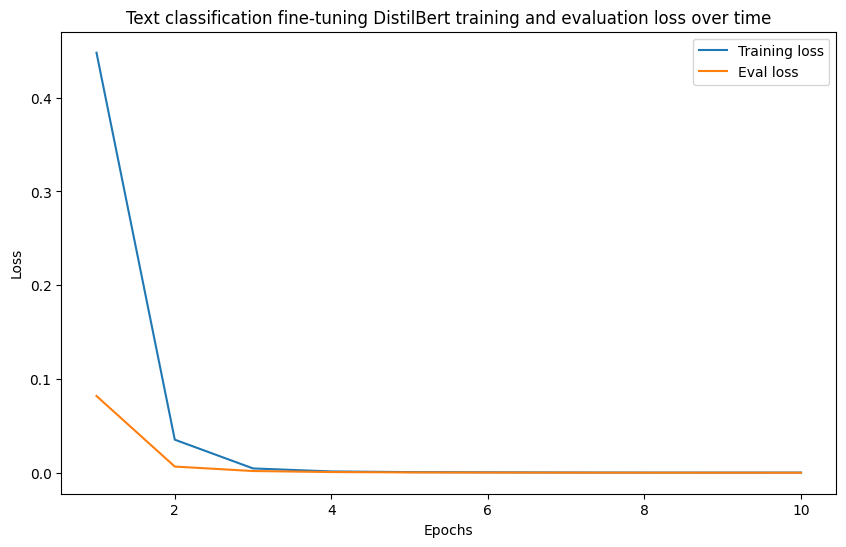

In [83]:
# Plot the loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(trainer_history_train_df['epoch'], trainer_history_train_df['loss'], label="Training loss")
plt.plot(trainer_history_eval_df['epoch'], trainer_history_eval_df['eval_loss'], label='Eval loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Text classification fine-tuning DistilBert training and evaluation loss over time")
plt.legend()
plt.show()
# Underfitting -> loss is not going down. Fixed by introducing more learning capacity (more data, more parameters in the model, longer training)
# Overfitting -> the loss value on the training set is lower than the loss value on the testing set. Fixed by introducing more regularization.
# Machine learning is a constsnt battle between overfitting and underfitting.

## Pushing the model to Hugging Face Hub
To keep a history of different model versions.

To write to HuggingFace:
* If on Google Colab setup token with read and write access.
* If on local machine setup huggingface-cli.

To save to the Hugging Face Hub we can use `Trainer.push_to_to_hub` method.

In [84]:
# Save the model to the Hugging Face Hub
model_upload_url = trainer.push_to_hub(
    commit_message="Uploading my first model food not food text classifier model",
    # token="YOUR_TOKEN"
)
print(f"NOTICE!!! Model successfully uploaded to the Hugging Face Hub with url: {model_upload_url}")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

NOTICE!!! Model successfully uploaded to the Hugging Face Hub with url: https://huggingface.co/Saint5/hg_tutorial_food_not_food_text_classifier_distilbert_base_uncased/tree/main/


## Making and evaluating predictions on the test data
**NOTE**: Evaluating a model is as important as training a model.

In [85]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
})

In [86]:
# Perform predictions on the test dataset
predictions_all = trainer.predict(tokenized_dataset['test'])
prediction_values = predictions_all.predictions # logits
prediction_metrics = predictions_all.metrics

print("[INFO] Prediction metrics on the test data:")
prediction_metrics

[INFO] Prediction metrics on the test data:


{'test_loss': 0.0005350123392418027,
 'test_accuracy': 1.0,
 'test_runtime': 0.0869,
 'test_samples_per_second': 575.371,
 'test_steps_per_second': 23.015}

In [87]:
# prediction_values

In [88]:
predictions_all.label_ids

array([1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1])

In [89]:
len(predictions_all.label_ids)

50

In [90]:
tokenized_dataset['test']

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 50
})

### Getting prediction probabilities and evaluate by hand

In [91]:
# Predicted logits (raw output of the model) -> prediction probabilities with torch.softmax ->
import torch
from sklearn.metrics import accuracy_score

# 1. Get prediction probabilities with torch.softmax
pred_probs = torch.softmax(torch.tensor(prediction_values), dim=1)

# 2. Get the predicted labels
pred_labels = torch.argmax(pred_probs, dim=1)

# 3. Get the true labels
true_labels = tokenized_dataset['test']['label']

# 4. Compute prediction labels to true labels and get the test accuracy
test_accuracy = accuracy_score(y_true=true_labels,
                               y_pred=pred_labels)

print(f"[MESSAGE] Test accuracy: {test_accuracy*100}")

[MESSAGE] Test accuracy: 100.0


### Exploring model's prediction probabilities
A very good way to evaluate a model by sorting predictions by prediction probabilities and seeing where the model went wrong.

In [92]:
# Make a DataFrame of test predictions
test_predictions_df = pd.DataFrame({
    "text":tokenized_dataset['test']['text'],
    "true_label":true_labels,
    "pred_label":pred_labels,
    "pred_prob":torch.max(pred_probs, dim=1).values
})
test_predictions_df.head()

,text,true_label,pred_label,pred_prob
0,A slice of pepperoni pizza with a layer of mel...,1,1,0.999480
1,Red brick fireplace with a mantel serving as a...,0,0,0.999497
2,A bowl of sliced bell peppers with a sprinkle ...,1,1,0.999478
3,Set of mugs hanging on a hook,0,0,0.999528
4,Standing floor lamp providing light next to an...,0,0,0.999518


In [93]:
# Show 10 examples with low prediction probability
test_predictions_df.sort_values("pred_prob", ascending=True).head(10)

,text,true_label,pred_label,pred_prob
43,Set of muffin tins stacked together,0,0,0.998576
40,A bowl of cherries with a sprig of mint for ga...,1,1,0.999384
14,Two handfuls of bananas in a fruit bowl with g...,1,1,0.999455
20,"Pizza with a seafood theme, featuring toppings...",1,1,0.999460
42,"Boxes of apples, pears, pineapple, manadrins a...",1,1,0.999461
26,A fruit platter with a variety of exotic fruit...,1,1,0.999462
11,A close-up shot of a cheesy pizza slice being ...,1,1,0.999465
35,Luxurious coconut shrimp curry on a generous p...,1,1,0.999466
13,"Comforting lamb curry bowl, featuring tender l...",1,1,0.999468
32,"Comforting lentil dal curry, featuring nutty l...",1,1,0.999469


## Making and inspecting predictions on custom text data

In [94]:
local_model_path = "models/hg_tutorial_food_not_food_text_classifier_distilbert_base_uncased"
huggingface_model_path = "Saint5/hg_tutorial_food_not_food_text_classifier_distilbert_base_uncased"

### Discussing ways to make predictions (inference)

In [95]:
# Setup the device for making predictions
# The faster the hardware accelerator the faster the predictions.
def set_device():
  if torch.cuda.is_available():
    device = torch.device('cuda')
  elif torch.backends.mps.is_available() and torch.backends.mps.is_built(): # for mac
    device = torch.device('mps')
  else:
    device = torch.device('cpu')
  return device

DEVICE = set_device()
print(f"[NOTICE!!] Using device: {DEVICE}")

[NOTICE!!] Using device: cuda


### Making predictions with pipeline mode

In [96]:
import torch
from transformers import pipeline

# Set the batch size
BATCH_SIZE = 32

# Create an instance of transformers.pipeline
food_not_food_classifier = pipeline(task="text-classification",
                                    model=local_model_path,
                                    device=DEVICE,
                                    top_k=1,
                                    batch_size=BATCH_SIZE)

food_not_food_classifier

Device set to use cuda


In [97]:
test_custom_sentence="Did you eat all the pasta?"
food_not_food_classifier(test_custom_sentence)

[[{'label': 'food', 'score': 0.9969866871833801}]]

In [98]:
not_food_sentence = "Where is my laptop that I used to order coffee with?"

In [99]:
food_not_food_classifier(not_food_sentence)

[[{'label': 'not_food', 'score': 0.9993784427642822}]]

In [100]:
del food_not_food_classifier

In [101]:
# Using pipeline with a model from Hugging Face
food_not_food_classifier = pipeline(task="text-classification",
                                    model=huggingface_model_path,
                                    device=DEVICE,
                                    top_k=1,
                                    batch_size=BATCH_SIZE)
food_not_food_classifier(not_food_sentence)

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda


[[{'label': 'not_food', 'score': 0.9993784427642822}]]

### Making multiple predictions

In [102]:
# Create a list of sentences to make predictions on
sentences = [
    "I whipped up a fresh batch of code, but it seems to have a syntax error.",
    "We need to marinate these ideas overnight before presenting them to the client.",
    "The new software is definitely a spicy upgrade, taking some time to get used to.",
    "Her social media post was the perfect recipe for a viral sensation.",
    "He served up a rebuttal full of facts, leaving his opponent speechless.",
    "The team needs to simmer down a bit before tackling the next challenge.",
    "The presentation was a delicious blend of humor and information, keeping the audience engaged.",
    "A beautiful array of fake wax foods (shokuhin sampuru) in the front of a Japanese restaurant.",
    "Daniel Bourke is really cool :D",
    "My favoruite food is biltong!"
]

food_not_food_classifier(sentences)

[[{'label': 'food', 'score': 0.8415461182594299}],
 [{'label': 'not_food', 'score': 0.9883488416671753}],
 [{'label': 'food', 'score': 0.9968271851539612}],
 [{'label': 'not_food', 'score': 0.8157719969749451}],
 [{'label': 'not_food', 'score': 0.9705728888511658}],
 [{'label': 'not_food', 'score': 0.9828698039054871}],
 [{'label': 'not_food', 'score': 0.5466797947883606}],
 [{'label': 'food', 'score': 0.9994127750396729}],
 [{'label': 'not_food', 'score': 0.9820641279220581}],
 [{'label': 'food', 'score': 0.9991138577461243}]]

In [103]:
example_sentence_batch = [
    "I baked a delicious apple pie for dessert last night.",
    "The meeting was a stew of different opinions and ideas.",
    "She whipped up a fantastic pasta dish for dinner.",
    "The project was a recipe for disaster from the start.",
    "He grilled some burgers and hot dogs for the barbecue.",
    "The team needs to cook up a new strategy to win the game.",
    "We enjoyed a gourmet meal at the new French restaurant downtown.",
    "The presentation was a feast for the eyes with its vibrant visuals.",
    "She prepared a fresh salad with tomatoes, cucumbers, and lettuce.",
    "The software update is a hot dish of new features and improvements.",
    "He ordered a large pizza with extra cheese and pepperoni.",
    "The debate was a simmering pot of conflicting viewpoints.",
    "We had a delightful spread of sushi and sashimi at the party.",
    "The book was a rich blend of history and fiction.",
    "She made a batch of chocolate chip cookies for the bake sale."
]

In [104]:
food_not_food_classifier(example_sentence_batch)
# model is inaccurate
# To improve, take the examples that the model got wrong and use them to retrain the model

[[{'label': 'food', 'score': 0.9994518160820007}],
 [{'label': 'not_food', 'score': 0.9856306910514832}],
 [{'label': 'food', 'score': 0.9991784691810608}],
 [{'label': 'not_food', 'score': 0.9615810513496399}],
 [{'label': 'food', 'score': 0.9994388222694397}],
 [{'label': 'not_food', 'score': 0.9974138140678406}],
 [{'label': 'food', 'score': 0.6370210647583008}],
 [{'label': 'not_food', 'score': 0.8110537528991699}],
 [{'label': 'food', 'score': 0.9994663596153259}],
 [{'label': 'not_food', 'score': 0.9541054964065552}],
 [{'label': 'food', 'score': 0.9994712471961975}],
 [{'label': 'not_food', 'score': 0.9327818751335144}],
 [{'label': 'food', 'score': 0.9994279742240906}],
 [{'label': 'not_food', 'score': 0.7649184465408325}],
 [{'label': 'food', 'score': 0.9994226694107056}]]

## Time the model across larger sample sizes

In [105]:
sentence_batch = sentences + example_sentence_batch
len(sentence_batch)

25

In [106]:
import time

# Create 1000 sentences
sentences_1000 = sentence_batch*40

# Time how long it takes to make predictions on all sentences (one at a time)
print(f"[INFO] Number of sentences: {len(sentences_1000)}")
start_timer_one_at_time = time.time()
for sentence in sentences_1000:
  # Make a prediction
  food_not_food_classifier(sentence)
end_timer_one_at_time = time.time()

total_time_one_at_time = end_timer_one_at_time - start_timer_one_at_time
avg_time_taken = total_time_one_at_time/len(sentences_1000)
print(f"[INFO] Total time for making predictions on {len(sentences_1000)} samples one at a time is: {total_time_one_at_time} seconds")
print(f"[INFO] Avg time per prediction one at a time: {avg_time_taken} seconds")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[INFO] Number of sentences: 1000
[INFO] Total time for making predictions on 1000 samples one at a time is: 5.18861198425293 seconds
[INFO] Avg time per prediction one at a time: 0.00518861198425293 seconds


In [107]:
#  Using pipeline in batches
for i in [10, 100, 1000, 10000]:
  sentences_big = sentence_batch*i
  print(f"[INFO] Number of sentences: {len(sentences_big)}")

  start_time = time.time()
  # Predict on all sentences in batch mode
  food_not_food_classifier(sentences_big)
  end_time = time.time()

  total_time_per_all_sentences_batch_mode = end_time - start_time
  avg_time_per_sentence_batch_mode = total_time_per_all_sentences_batch_mode/len(sentences_big)

  print(f"[INFO] Inference time for {len(sentences_big)} sentences batch mode: {round(total_time_per_all_sentences_batch_mode, 6)}")
  print(f"[INFO] Avg inference time per sentence: {round(avg_time_per_sentence_batch_mode, 6)}")
  print()

[INFO] Number of sentences: 250
[INFO] Inference time for 250 sentences batch mode: 0.225915
[INFO] Avg inference time per sentence: 0.000904

[INFO] Number of sentences: 2500
[INFO] Inference time for 2500 sentences batch mode: 1.972903
[INFO] Avg inference time per sentence: 0.000789

[INFO] Number of sentences: 25000
[INFO] Inference time for 25000 sentences batch mode: 20.076502
[INFO] Avg inference time per sentence: 0.000803

[INFO] Number of sentences: 250000
[INFO] Inference time for 250000 sentences batch mode: 220.057493
[INFO] Avg inference time per sentence: 0.00088



### Making predictions with PyTorch
Steps:
1. Create tokenizer with `AutoTokenizer`.
2. Create the model with AutoModel (AutoModelForSequenceClassification).
3. Tokenize text with 1
4. Make prediction with 2
5. Format predction

In [108]:
from transformers import AutoTokenizer

# Setup the model path
model_path = huggingface_model_path

# Create an example to predict on
sample_food_text = "A delicious photo of strawberry lavender cake"

# Prepare tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_path)
inputs = tokenizer(sample_food_text,
                   return_tensors='pt') # 'pt' stands for PyTorch
inputs

{'input_ids': tensor([[  101,  1037, 12090,  6302,  1997, 16876, 20920,  9850,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [109]:
from transformers import AutoModelForSequenceClassification

# Load the text classification model
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_path)
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [110]:
import torch

model.eval()
# with torch.no_grad()
with torch.inference_mode():
  outputs = model(**inputs) # "**" (keyword arguments) means input all of the dictionary keys as named arguments/parameters
  outputs_verbose = model(input_ids=inputs['input_ids'],
                          attention_mask=inputs['attention_mask'])
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-3.7648,  3.7127]]), hidden_states=None, attentions=None)

In [111]:
outputs_verbose

SequenceClassifierOutput(loss=None, logits=tensor([[-3.7648,  3.7127]]), hidden_states=None, attentions=None)

In [112]:
model.config.id2label

{0: 'not_food', 1: 'food'}

In [113]:
# Convert logits to prediction probability + label
predicted_class_id = outputs.logits.argmax().item() # '.item()' makes it to be no longer a tensor
predicted_probability = torch.softmax(outputs.logits, dim=1).max().item()

print(f"Text: {sample_food_text}")
print(f"Predicted label: {model.config.id2label[predicted_class_id]}")
print(f"Prediction probability: {predicted_probability}")

Text: A delicious photo of strawberry lavender cake
Predicted lable: food
Prediction probability: 0.9994346499443054


In [114]:
food_not_food_classifier(sample_food_text)

[[{'label': 'food', 'score': 0.9994346499443054}]]

## **PUTTING IT ALL TOGETHER**

In [115]:
# 1. Import necessary packages
import pprint
from pathlib import Path

import numpy as np
import torch

import datasets
import evaluate

from transformers import pipeline, TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split

# 2. Setup variables for model training and saving pipeline
DATASET_NAME = "mrdbourke/learn_hf_food_not_food_image_captions"
MODEL_NAME = "distilbert/distilbert-base-uncased"
MODEL_SAVE_DIR_NAME = "models/hf_tutorial_food_not_food_text_classifier-distilbert-base-uncased"

# 3. Create a directory for saving models
model_save_dir = Path(MODEL_SAVE_DIR_NAME)
model_save_dir.mkdir(parents=True, exist_ok=True)

# 4. Load and preprocess the dataset from Hugging Face Hub
print(f"[INFO] Downloading dataset from Hugging Face Hub, name: {DATASET_NAME}")
dataset = datasets.load_dataset(DATASET_NAME)

# Perform mappings for the labels to id and vice versa
# id2label = {idx:label for idx,label in enumerate(dataset['train'].unique('label')[::-1])}
# label2id = {label:id for idx,label in id2label.items()}
# Option: hardcode
id2label = {0:"not_food", 1:"food"}
label2id = {"not_food":0, "food":1}

# Create a function to map IDs to labels in dataset (labels to numeric values)
def map_labels_number(example):
  example['label'] = label2id[example['label']]
  return example

# Map the preprocessing function to the dataset
dataset = dataset['train'].map(map_labels_to_number)

# Split the dataset into train/test sets
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# 5. Import a tokenizer and map it to the dataset
print(f"[INFO] Tokenizing text for model training with tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=MODEL_NAME,
                                          use_fast=True)
# Create function to tokenize text samples (turn text to numeric numbers)
def tokenize_text(examples):
  return tokenizer(examples['text'],
                   padding=True,
                   truncation=True)

tokenized_dataset = dataset.map(function=tokenize_text,
                                batched=True,
                                batch_size=1000)

# 6. Setup an evaluation metric
accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels):
  predictions, labels = predictions_and_labels

  # Model will output logits in the form [[item_1, item_2, item_3],[item_1, item_2, item_3]] depending on the type of data, the number of classes you have
  # But we want to compare labels which are in the format of ([0,0,0,0,1])
  if len(predictions.shape) >= 2:
    predictions = np.argmax(predictions, axis=1)
  return accuracy_metric.compute(predictions=predictions, references=labels)

# 7. Setup the model
print(f"[INFO] Loading model: {MODEL_NAME}")
model=AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=MODEL_NAME,
                                                     num_labels=2,
                                                     id2label=id2label,
                                                     label2id=label2id)

print(f"[INFO] Model loading complete!!!")

# Setup TrainArguments (these are hyperparameters for the model)
training_args=TrainingArguments(
    output_dir=model_save_dir,
    learning_rate=0.0001,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    use_cpu=False,
    seed=42,
    load_best_model_at_end=True,
    logging_strategy="epoch",
    report_to="none",
    push_to_hub=False,
    hub_private_repo=False # This will make the model public by default
)
# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    processing_class=tokenizer,
    compute_metrics=compute_accuracy
)

# 8. Train the model
print(f"[INFO] Commencing model training...")
results = trainer.train()

# 9. Ssave the train model (to a local directory)
print(f"[INFO] Model training complete, saving the model to loacal path: {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)

# 10. Push the model to the Hugging Face Hub
print(f"[INFO] Uploading model to Hugging Face Hub...")
model_upload_url = trainer.push_to_hub(
    commit_message="Second commit of the text classifier model",
    # token "YOUR_TOKEN_HERE"
)
print(f"[INFO] Model upload complete, model availabel at: {model_upload_url}")

# 11. Evaluate the model on the test data
print(f"[INFO] Performing evaluation test dataset...")
predictions_all = trainer.predict(tokenized_dataset['test'])
prediction_values = predictions_all.predictions
prediction_metrics = predictions_all.metrics

print(f"[INFO] Prediction metrics on test data:")
pprint.pprint(prediction_metrics)

[INFO] Downloading dataset from Hugging Face Hub, name: mrdbourke/learn_hf_food_not_food_image_captions
[INFO] Tokenizing text for model training with tokenizer: distilbert/distilbert-base-uncased


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

[INFO] Loading model: distilbert/distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Model loading complete!!!
[INFO] Commencing model training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.426700,0.105709,0.980000
2,0.047900,0.009158,1.000000
3,0.005300,0.047959,0.980000
4,0.001900,0.069390,0.980000
5,0.001100,0.074668,0.980000
6,0.000800,0.073731,0.980000
7,0.000700,0.072083,0.980000
8,0.000600,0.070217,0.980000
9,0.000600,0.069074,0.980000
10,0.000600,0.068684,0.980000


[INFO] Model training complete, saving the model to loacal path: models/hf_tutorial_food_not_food_text_classifier-distilbert-base-uncased
[INFO] Uploading model to Hugging Face Hub...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

[INFO] Model upload complete, model availabel at: https://huggingface.co/Saint5/hf_tutorial_food_not_food_text_classifier-distilbert-base-uncased/tree/main/
[INFO] Performing evaluation test dataset...


[INFO] Prediction metrics on test data:
{'test_accuracy': 1.0,
 'test_loss': 0.009158377535641193,
 'test_runtime': 0.0874,
 'test_samples_per_second': 572.02,
 'test_steps_per_second': 22.881}


In [116]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
})

In [117]:
print(local_model_path)
print(model_save_dir)

models/hg_tutorial_food_not_food_text_classifier_distilbert_base_uncased
models/hf_tutorial_food_not_food_text_classifier-distilbert-base-uncased


In [118]:
# 12. Make sure the model works by testing it on a custom sample
from transformers import pipeline
food_not_food_classifier = pipeline(task="text-classification",
                                    model=model_save_dir,
                                    device="cuda" if torch.cuda.is_available() else "cpu",
                                    top_k=1,
                                    batch_size=32 # incase of batch predictions
                                    )
food_not_food_classifier("I had beef ribs at the restaurant yesterday.")

Device set to use cuda


[[{'label': 'food', 'score': 0.9825825691223145}]]

## Turning the model into shareable demo using Gradio

### Creating a function to perform inference
1. Take an input of string.
2. Setup a text classification pipeline.
3. Get the output from the pipeline.
4. Return the output from the pipeline in step 3 as a formatted dictionary with the format: `[{"label_1":"probability_1"},{"label_2":"probability_2"}]`

In [119]:
# from typing import Dict

# # 1. Create a function to take a string input
# def food_not_food_classifier(text:str) -> Dict[str, float]:
#   # 2. Setup food not food classifier
#   food_not_food_classifier_pipeline=pipeline(task="text-classification",
#                                     model=model_save_dir,
#                                     batch_size=32,
#                                     device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
#                                     top_k=None # returns all possible labels
#                                     )
#   # 3. Get the outputs from the pipeline
#   outputs = food_not_food_classifier_pipeline(text)[0]

#   output_dict = {}
#   for item in outputs:
#     output_dict[item['label']] = item['score']

#     return output_dict

# food_not_food_classifier(text='I need a tall glass of cold mojito and some fajitas mate.')

In [122]:
from typing import Dict
# Load the pipeline only once
food_not_food_classifier_pipeline = pipeline(
    task='text-classification',
    model=model_save_dir,
    batch_size=32,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    top_k=None
)

def food_not_food_classifier(text: str) -> Dict[str, float]:
    outputs = food_not_food_classifier_pipeline(text)[0]
    return {item['label']: item['score'] for item in outputs}

food_not_food_classifier(text='I need a tall glass of cold mojito and some fajitas mate.')

Device set to use cuda


{'food': 0.9899895191192627, 'not_food': 0.010010470636188984}

### Building a small Gradio demo to run locally

In [123]:
# 1. Import gradio
import gradio as gr

# 2. Create a gradio interface
demo = gr.Interface(
    fn=food_not_food_classifier,
    inputs='text',
    outputs=gr.Label(num_top_classes=2),
    title="Food Not Food Classifier 🍝🚫🍺🍽️",
    description="A text classifier to determine if a sentence is about food or not.",
    examples=[['The presentation was a delicious blend of humor and information, keeping the audience engaged'],
              ['A plate of salmon with salad as side dish']]
)
# 3. Launch the interface
demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://79f0894ca938d3da75.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Making the demo publicly accessible
There are 2 ways that the demo can be made:
1. Manually - creating a new space in Hugging Face spaces, add files and publish.
2. Programmatically - using the Hugging Face Hupython API and the files to a space with code.


To create a space programmatically we're going to need these three files:
1. `app.py`
2. `requiremnts.txt`
3. `README.md` - explains what the project demo is about and will aslo add some metadata in YAML format.

Following the programmatically path with the following file strucure:

```
  demos/
      |__ food_not_food_text_classifier/
      |__ app.py
      |__ README.md
      |__ requirements.txt
```

### Making a directory to store the demo

In [133]:
from pathlib import Path

# Make directory for demos
demos_dir = Path("../demos")
demos_dir.mkdir(exist_ok=True)

# Create a food not food text classifier demo directory
food_not_food_text_classifier_demo_dir = Path(demos_dir, "food_not_food_text_classifier")
food_not_food_text_classifier_demo_dir.mkdir(exist_ok=True)

In [129]:
# print(demos_dir.resolve())

### Making an `app.py`
The file will contain the main logic of the application to run.

When uploaded to HF Spaces will try to to run it automatically.

This file will contain:
1. Importing packages to be used.
2. Defining the function to be used by the model (this will work with Gradio).
3. Creating a demo with Gradio
4. Run the demo with `demo.launch()`

In [163]:
%%writefile ../demos/food_not_food_text_classifier/app.py
# Import required packages
import torch
import gradio as gr

from typing import Dict
from transformers import pipeline

# 2. Define the function to use with the model
def food_not_food_classifier(text:str) -> Dict[str, float]:
  food_not_food_classifier_pipeline=pipeline(task='text-classification',
                                             model='Saint5/hg_tutorial_food_not_food_text_classifier_distilbert_base_uncased', # model already in hugging face
                                             batch_size=32,
                                             device='cuda' if torch.cuda.is_available() else 'cpu',
                                             top_k=None)
  outputs = food_not_food_classifier_pipeline(text)[0]

  # Format output for gradio
  output_dict = {}
  for item in outputs:
    output_dict[item['label']] = item['score']

  return output_dict

# 3. Create a Gradio interface
description = """
This is a text classification model that identifies whether a sentence is related to food topics or not.

The model is finetuned from DistilBERT.
"""

demo  = gr.Interface(
            fn=food_not_food_classifier,
            inputs='text',
            outputs=gr.Label(num_top_classes=2),
            title="Food🍝 not🚫 Food🍲 Text Classifier🤖",
            description=description,
            examples=[['The presentation was a delicious blend of humor and information, keeping the audience engaged'],
                      ['A plate of salmon with salad as side dish']],
)

# 4. Launch the app
if __name__ == "__main__":
  demo.launch()

Overwriting ../demos/food_not_food_text_classifier/app.py


In [158]:
# %%writefile ../demos/food_not_food_text_classifier/app.py

# import torch
# import gradio as gr
# from typing import Dict
# from transformers import pipeline

# # Load pipeline once
# food_not_food_classifier_pipeline = pipeline(
#     task='text-classification',
#     model='Saint5/hg_tutorial_food_not_food_text_classifier-distilbert-base-uncased',
#     batch_size=32,
#     device=0 if torch.cuda.is_available() else -1,
#     top_k=None
# )

# def food_not_food_classifier(text: str) -> Dict[str, float]:
#     outputs = food_not_food_classifier_pipeline(text)[0]
#     return {item['label']: item['score'] for item in outputs}

# # Gradio interface
# description = """
# This is a text classification model that identifies whether a sentence is related to food topics or not.
# The model is finetuned from DistilBERT.
# """

# demo = gr.Interface(
#     fn=food_not_food_classifier,
#     inputs='text',
#     outputs=gr.Label(num_top_classes=2),
#     title="Food🍝 not🚫 Food🍲 Text Classifier🤖",
#     description=description,
#     examples=[['The presentation was a delicious blend of humor and information, keeping the audience engaged'],
#               ['A plate of salmon with salad as side dish']],
#     cache_examples=False
# )

# if __name__ == "__main__":
#     demo.launch(ssr_mode=False, server_port=7861)


### Making a `README.md` file
The file is in markdown format.

With special YAML block at the top.

The YAML block at the top is used for metadata + settings

In [164]:
%%writefile ../demos/food_not_food_text_classifier/README.md
---
title: Food not Food Text Classifier
emoji: 🍲🥙🍟
colorFrom: blue
colorTo: yellow
sdk: gradio
sdk_version: 5.30.0
app_file: app.py
pinned: false
license: apache-2.0
---

# Food not Food Text Classifier 🍲🚫🥙

Is it food or not? 🍕🤖 Let this classifier decide if your sentence belongs on a menu or in a memo.

Built with DistilBERT magic!

Model is fine-tuned on a small synthetic dataset of 250 generated food/not food sentence captions.

Overwriting ../demos/food_not_food_text_classifier/README.md


### Making a requirements file
Tells the Hugging Face Space which versions/packages to use.

If this file is not created an error will occur, `ModuleNotFoundError`.

In [165]:
%%writefile ../demos/food_not_food_text_classifier/requirements.txt
gradio
torch
transformers

Overwriting ../demos/food_not_food_text_classifier/requirements.txt


## Uploading the demo to Hugging Face Spaces
To do so, we'll use the Hugging Face Hub Python API.

To get the demo on HF spaces, the following can be done:
1. Import necessary functions.
2. Define what is to be uploaded.
3. Create a repo.
4. Get the name of the repo from the upload.
5. Upload the contents of `../demos/food_not_food_text_classifier/` to HF Hub repo.
6. If it all works inspect the results.

In [166]:
# 1. Import the requiured methods for uploading to the HF Hub
from huggingface_hub import (
    create_repo,
    get_full_repo_name,
    upload_file,
    upload_folder
)

# 2. Define the parameters likely to be used for uploading the Space
LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD = '../demos/food_not_food_text_classifier'
HF_TARGET_SPACE_NAME = 'hg_tutorial_food_not_food_text_classifier_demo'
HF_REPO_TYPE = 'space'
HF_SPACE_SDK = 'gradio'
# HF_TOKEN = ""

# 3. Create a Space repo on Hugging Face Hub
print(f"[INFO] Creating repo on Hugging Face Hub with name: {HF_TARGET_SPACE_NAME}")
create_repo(
    repo_id=HF_TARGET_SPACE_NAME,
    # token="HF_TOKEN",
    private=False, # set to True if you want your repo to be private
    repo_type=HF_REPO_TYPE,
    space_sdk=HF_SPACE_SDK,
    exist_ok=True
)

# 4. Get the full repo name (e.g. {username}/{repo_name})
hf_full_repo_name=get_full_repo_name(model_id=HF_TARGET_SPACE_NAME)
print(f"[INFO] Full Hugging Face Hub repo name: {hf_full_repo_name}")

# 5. Upload the demo folder
print(f"[INFO] Uploading {LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD} to repo: {hf_full_repo_name}")
folder_upload_url = upload_folder(
    repo_id=hf_full_repo_name,
    folder_path=LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD,
    path_in_repo=".", # where you'd like your folder to be (in this case current directory)
    # token='HF_TOKEN',
    repo_type=HF_REPO_TYPE,
    commit_message="Uploading my first ever model demo to Hugging Face"
)

print(f"[INFO] Demo folder successfully uploaded with commit URL: {folder_upload_url}")

[INFO] Creating repo on Hugging Face Hub with name: hg_tutorial_food_not_food_text_classifier_demo
[INFO] Full Hugging Face Hub repo name: Saint5/hg_tutorial_food_not_food_text_classifier_demo
[INFO] Uploading ../demos/food_not_food_text_classifier to repo: Saint5/hg_tutorial_food_not_food_text_classifier_demo
[INFO] Demo folder successfully uploaded with commit URL: https://huggingface.co/spaces/Saint5/hg_tutorial_food_not_food_text_classifier_demo/tree/main/.


### Embedding the Hugging Face Space

In [171]:
from IPython.display import HTML

HTML(data='''
<iframe
	src="https://saint5-hg-tutorial-food-not-food-text-classifier-demo.hf.space"
	frameborder="0"
	width="900"
	height="500"
></iframe>
''')